In [10]:
import pandas as pd
import numpy as np

from pathlib import Path
import warnings
import sys
print(sys.path)
sys.path.append('../modules/')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

train_origin = pd.read_csv('../input/train.csv')
test_origin = pd.read_csv('../input/test.csv')

df_train = train_origin.copy()
df_test = test_origin.copy()

df_sample_sub = pd.read_csv('../input/sample_submit.csv', header=None)
df_sample_sub.columns = ['index', 'genre']
df_genre_labels = pd.read_csv('../input/genre_labels.csv')

['/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/notebooks', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages', '/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/IPython/extensions', '/Users/shugo/.ipython', '../modules/']


In [13]:
N_CLASSES = 11

# testのジャンルを-100として結合
def merge_train_test(df_train, df_test):
    if 'genre' not in df_test.columns.tolist():
        df_test['genre'] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop = True)
    return res

def split_train_test(df):
    df_train = df[df['genre'] != -100]
    df_test = df[df['genre'] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop =True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [17]:
for pseudo_labeling_threshold in [0.95, 0.925, 0.9, 0.875, 0.85, -np.inf]:
    df = df_main.copy()

    # feature enginnering

    df['genre_name'] = df['genre'].map(dict(df_genre_labels[['labels', 'genre']].values))

    # tempoを平均値に変換
    df['tempo'] = df['tempo'].map(lambda x : sum(map(int, x.split('-')))/2)

    # regionをone-hotし、unknownをregion_unknownとする
    df = pd.concat([df, pd.get_dummies(df['region']).rename(columns={'unknown' : 'region_unknown'})], axis=1)

    # 曲ごとのnanの数
    df['num_nans'] = 0
    for col in [
        'acousticness',
        'positiveness',
        'danceability',
        'energy',
        'liveness',
        'speechiness',
        'instrumentalness'
    ]:
        df['num_nans'] += df[col].isna()


    # regionについてgroupbyし、???
    class CountEncoder:
        def fit(self, series):
            self.counts = series.groupby(series).count()
            return self

        def transform(self, series):
            return series.map(self.counts).fillna(0)

        def fit_transform(self, series):
            return self.fit(series).transform(series)

    columns_count_enc = ['region']
    for col in columns_count_enc:
        df['countenc_' + col] = CountEncoder().fit_transform(df[col])
        df.loc[df[col].isna().values, 'countenc_' + col] = np.nan


    # LabelEncoding
    columns_label_enc = ['region']
    for col in columns_count_enc:
        df['labelenc_' + col] = LabelEncoder().fit_transform(df[col])
        df.loc[df[col].isna().values, 'labelenc_' + col] = np.nan


    #　標準偏差とz得点
    class GroupFeatureExtractor:
        EX_TRANS_METHODS = ['deviation', 'zscore']

        def __init__(self, group_key, group_values, agg_methods):
            self.group_key = group_key
            self.group_values = group_values

            self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
            self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
            self.df_agg = None

        def fit(self, df_train, y=None):
            if not self.agg_methods:
                return
            dfs = []
            for agg_method in self.agg_methods:
                if callable(agg_methods): # 呼び出し可能か判定
                    agg_method_name = agg_method.__name__ # ?
                else:
                    agg_method_name = agg_method
                df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
                df_agg.columns = self._get_columns_names(agg_method_name)
                dfs.append(df_agg)
            self.df_agg = pd.concat(dfs, axis=1).reset_index()

        def transform(self, df_eval):
            key = self.group_key
            if self.agg_methods:
                df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how='left')
            else:
                df_features = df_eval[[self.group_key]].copy()
            if self.ex_trans_methods:
                if 'deviation' in self.ex_trans_methods:
                    df_features[self._get_agg_column_names('deviation')] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')
                if 'zscore' in self.ex_trans_methods:
                    df_features[self._get_column_names('zscore')] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')) \
                                                                                                                / (df_eval[[key]+self.group_values].groupby(key).transform('std') + 1e-8)

                df_features.drop(self.group_key, axis=1, inplace = True)
                return df_features

        def _get_column_names(self, method):
            return [f'agg_{method}_{col}_grpby_{self.group_key}' for col in self.group_values]

        def fit_transform(self, df_train, y=None):
            self.fit(df_train, y=y)
            return self.transform(df_train)


    # tempoの対数を取る
    df['log_tempo'] = np.log(df['tempo'])
    # zscore
    gfe = GroupFeatureExtractor(
            'region',
            ['popularity', 'duration_ms', 'acousticness', 'positiveness','danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
            ['zscore']
    )
    df = pd.concat([df, gfe.fit_transform(df)], axis=1)


    # K近傍法特徴量
    class KNNFeatureExtractor:
        def __init__(self, n_neighbors=5):
            self.knn = KNeighborsClassifier(n_neighbors + 1)

        def fit(self, X, y):
            self.knn.fit(X, y)
            self.y = y if isinstance(y, np.ndarray) else np.array(y) # 型判定の組み込み関数isinstanceはboolを返す。np.arrayのyを返す
            return self

        def transform(self, X, is_train_data):
            distances, indexes = self.knn.kneighbors(X) # ポイントXから最も近いポイントまでの距離と、そのインデックスを返す

            # train, testデータを判定
            distances = distances[:, 1:] if is_train_data else distances[:, :-1]
            indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
            labels = self.y[indexes]
            score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
            df_knn = pd.DataFrame(
                    [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)], # bincount : 要素の個数を返す
                    columns=score_columns
            )

            # 最大スコア
            df_knn['max_knn_scores'] = df_knn.max(axis=1)

            # 最大スコアとの差。0は最大スコアを表す
            for col in score_columns:
                df_knn[f'sub_max_knn_scores_{col}'] = df_knn['max_knn_scores'] - df_knn[col]

            # 最大スコアとの比。1は最大スコアを表す
            for col in score_columns:
                df_knn[f'div_max_knn_scores_{col}'] = df_knn[col] / df_knn['max_knn_scores']

            # それぞれのスコア同士の差
            for i, col1 in enumerate(score_columns):
                for j, col2 in enumerate(score_columns[i+1:], i+1): # 全パターンを網羅できる
                    df_knn[f'sub_{col1}_{col2}'] = df_knn[col1] - df_knn[col2]

            # knnスコアの合計
            df_knn['sum_knn_scores'] = df_knn.sum(1)

            return df_knn

    # feature scaling

    df['log_tempo'] = np.log(df['tempo'])
    for col in [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
    ]:
        df['standardscaled_' + col] = StandardScaler().fit_transform(df[[col]])[:, 0]


    df_train, df_test = split_train_test(df)
    target = df_train['genre']

    N_SPLITS = 15
    SEED_SKF = 42
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
    oof = np.zeros((len(df_train), N_CLASSES))
    predictions = np.zeros((len(df_test), N_CLASSES))
    df_feature_importance = pd.DataFrame()

    features_numerical = [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'tempo',
        'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
        'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
        'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
        'region_S', 'region_T', 'region_unknown', 'countenc_region',
        'num_nans',
        'agg_zscore_popularity_grpby_region',
        'agg_zscore_duration_ms_grpby_region',
        'agg_zscore_acousticness_grpby_region',
        'agg_zscore_positiveness_grpby_region',
        'agg_zscore_danceability_grpby_region',
        'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
        'agg_zscore_liveness_grpby_region',
        'agg_zscore_speechiness_grpby_region',
        'agg_zscore_instrumentalness_grpby_region',
        'agg_zscore_log_tempo_grpby_region',
        'knn_score_class00', 'knn_score_class01',
        'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
        'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
        'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
        'max_knn_scores',
        'div_max_knn_scores_knn_score_class00',
        'div_max_knn_scores_knn_score_class01',
        'div_max_knn_scores_knn_score_class02',
        'div_max_knn_scores_knn_score_class03',
        'div_max_knn_scores_knn_score_class04',
        'div_max_knn_scores_knn_score_class05',
        'div_max_knn_scores_knn_score_class06',
        'div_max_knn_scores_knn_score_class07',
        'div_max_knn_scores_knn_score_class08',
        'div_max_knn_scores_knn_score_class09',
        'div_max_knn_scores_knn_score_class10',
        'sub_max_knn_scores_knn_score_class00',
        'sub_max_knn_scores_knn_score_class01',
        'sub_max_knn_scores_knn_score_class02',
        'sub_max_knn_scores_knn_score_class03',
        'sub_max_knn_scores_knn_score_class04',
        'sub_max_knn_scores_knn_score_class05',
        'sub_max_knn_scores_knn_score_class06',
        'sub_max_knn_scores_knn_score_class07',
        'sub_max_knn_scores_knn_score_class08',
        'sub_max_knn_scores_knn_score_class09',
        'sub_max_knn_scores_knn_score_class10',
        'sum_knn_scores']
    sub_knn_score_n_m = []
    score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
    for i, col1 in enumerate(score_columns):
        for j, col2 in enumerate(score_columns[i+1:], i+1):
            sub_knn_score_n_m.append(f'sub_{col1}_{col2}')
    features_numerical += sub_knn_score_n_m        


    features_categorical = ['labelenc_region']
    features = features_numerical + features_categorical

    for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
        print('-'*50, 'fold{}'.format(fold_), '-'*50)

        df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
        df_val = df_train.loc[indexes_val].reset_index(drop=True)
        target_trn = target.loc[indexes_trn].reset_index(drop=True)
        target_val = target.loc[indexes_val].reset_index(drop=True)

        # make knn features
        X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights

        knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)

        df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)

        X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
        df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)

        X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
        df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)

        for col in df_test_knn_features.columns:
            df_test[col] = df_test_knn_features[col]

        lgb_train = lgb.Dataset(
                df_trn.loc[:, features],
                label=target_trn,
                feature_name=features,
                categorical_feature=features_categorical
        )
        lgb_valid = lgb.Dataset(
                df_val.loc[:, features],
                label=target_val,
                feature_name=features,
                categorical_feature=features_categorical
        )

        lgb_params['learning_rate'] = learning_rate + np.random.random() * 0.001 # おまじない
        num_round = 999999999
        model = lgb.train(
                lgb_params,
                lgb_train,
                num_round,
                valid_sets=[lgb_train, lgb_valid],
                verbose_eval=300,
                early_stopping_rounds=300 if num_round >=1e8 else None,
                fobj=None,
                #feval=lgb_metric,
        )

        # cv
        prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round # おまじない
        oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

        # feature importance
        df_fold_importance = pd.DataFrame()
        df_fold_importance['feature'] = features
        df_fold_importance['importance'] = model.feature_importance()
        df_fold_importance['fold'] = fold_
        df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

        # prediction for test data
        predictions += model.predict(df_test[features], num_iteration=prediction_round) /N_SPLITS
        print()

AttributeError: 'float' object has no attribute 'split'

CV score
f1 :  0.67034

              precision    recall  f1-score   support

           0       0.79      0.59      0.68        32
           1       0.58      0.45      0.51       205
           2       0.71      0.60      0.65       191
           3       0.81      0.77      0.79       362
           4       0.71      0.60      0.65        45
           5       0.61      0.50      0.55       126
           6       0.69      0.40      0.51        50
           7       0.65      0.62      0.64       334
           8       0.73      0.79      0.76      1305
           9       0.86      0.83      0.84        59
          10       0.79      0.82      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.72      0.63      0.67      4046
weighted avg       0.74      0.74      0.74      4046



/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


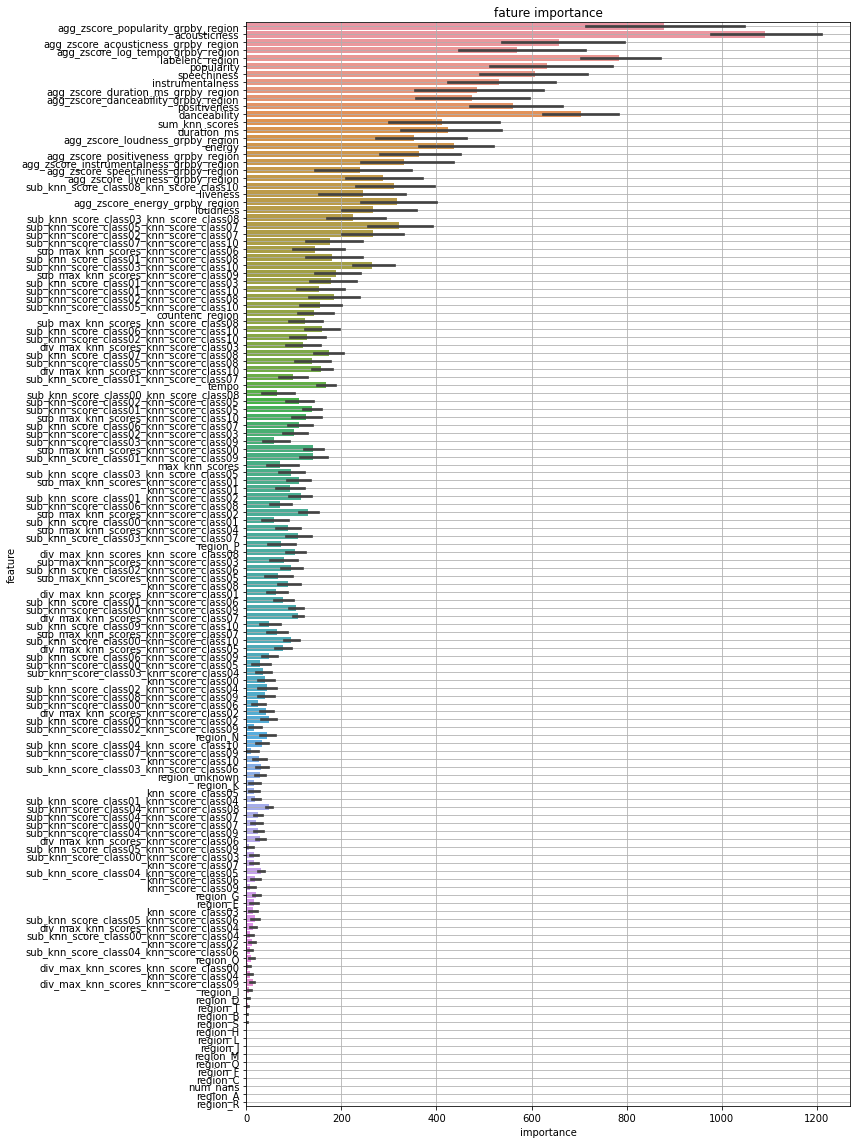

In [6]:
df_test.loc[:, 'prediction'] = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average='macro')
print('CV score')
print('f1 : {:8.5f}'.format(score))
print()
print(classification_report(target, oof.argmax(1)))

fig, ax= plt.subplots(figsize=(12, 16))
sns.barplot(x='importance', y='feature', data=df_feature_importance.sort_values(by='importance', ascending=False))
plt.title('fature importance')
ax.grid()
plt.tight_layout()
plt.show()

In [15]:
for pseudo_labeling_threshold in [0.95, 0.925, 0.9, 0.875, 0.85, -np.inf]:
    df = df_main.copy()

    # feature enginnering

    df['genre_name'] = df['genre'].map(dict(df_genre_labels[['labels', 'genre']].values))

    # tempoを平均値に変換
    df['tempo'] = df['tempo'].map(lambda x : sum(map(int, x.split('-')))/2)

    # regionをone-hotし、unknownをregion_unknownとする
    df = pd.concat([df, pd.get_dummies(df['region']).rename(columns={'unknown' : 'region_unknown'})], axis=1)

    # 曲ごとのnanの数
    df['num_nans'] = 0
    for col in [
        'acousticness',
        'positiveness',
        'danceability',
        'energy',
        'liveness',
        'speechiness',
        'instrumentalness'
    ]:
        df['num_nans'] += df[col].isna()


    # regionについてgroupbyし、???
    class CountEncoder:
        def fit(self, series):
            self.counts = series.groupby(series).count()
            return self

        def transform(self, series):
            return series.map(self.counts).fillna(0)

        def fit_transform(self, series):
            return self.fit(series).transform(series)

    columns_count_enc = ['region']
    for col in columns_count_enc:
        df['countenc_' + col] = CountEncoder().fit_transform(df[col])
        df.loc[df[col].isna().values, 'countenc_' + col] = np.nan


    # LabelEncoding
    columns_label_enc = ['region']
    for col in columns_count_enc:
        df['labelenc_' + col] = LabelEncoder().fit_transform(df[col])
        df.loc[df[col].isna().values, 'labelenc_' + col] = np.nan


    #　標準偏差とz得点
    class GroupFeatureExtractor:
        EX_TRANS_METHODS = ['deviation', 'zscore']

        def __init__(self, group_key, group_values, agg_methods):
            self.group_key = group_key
            self.group_values = group_values

            self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
            self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
            self.df_agg = None

        def fit(self, df_train, y=None):
            if not self.agg_methods:
                return
            dfs = []
            for agg_method in self.agg_methods:
                if callable(agg_methods): # 呼び出し可能か判定
                    agg_method_name = agg_method.__name__ # ?
                else:
                    agg_method_name = agg_method
                df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
                df_agg.columns = self._get_columns_names(agg_method_name)
                dfs.append(df_agg)
            self.df_agg = pd.concat(dfs, axis=1).reset_index()

        def transform(self, df_eval):
            key = self.group_key
            if self.agg_methods:
                df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how='left')
            else:
                df_features = df_eval[[self.group_key]].copy()
            if self.ex_trans_methods:
                if 'deviation' in self.ex_trans_methods:
                    df_features[self._get_agg_column_names('deviation')] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')
                if 'zscore' in self.ex_trans_methods:
                    df_features[self._get_column_names('zscore')] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')) \
                                                                                                                / (df_eval[[key]+self.group_values].groupby(key).transform('std') + 1e-8)

                df_features.drop(self.group_key, axis=1, inplace = True)
                return df_features

        def _get_column_names(self, method):
            return [f'agg_{method}_{col}_grpby_{self.group_key}' for col in self.group_values]

        def fit_transform(self, df_train, y=None):
            self.fit(df_train, y=y)
            return self.transform(df_train)


    # tempoの対数を取る
    df['log_tempo'] = np.log(df['tempo'])
    # zscore
    gfe = GroupFeatureExtractor(
            'region',
            ['popularity', 'duration_ms', 'acousticness', 'positiveness','danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
            ['zscore']
    )
    df = pd.concat([df, gfe.fit_transform(df)], axis=1)


    # K近傍法特徴量
    class KNNFeatureExtractor:
        def __init__(self, n_neighbors=5):
            self.knn = KNeighborsClassifier(n_neighbors + 1)

        def fit(self, X, y):
            self.knn.fit(X, y)
            self.y = y if isinstance(y, np.ndarray) else np.array(y) # 型判定の組み込み関数isinstanceはboolを返す。np.arrayのyを返す
            return self

        def transform(self, X, is_train_data):
            distances, indexes = self.knn.kneighbors(X) # ポイントXから最も近いポイントまでの距離と、そのインデックスを返す

            # train, testデータを判定
            distances = distances[:, 1:] if is_train_data else distances[:, :-1]
            indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
            labels = self.y[indexes]
            score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
            df_knn = pd.DataFrame(
                    [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)], # bincount : 要素の個数を返す
                    columns=score_columns
            )

            # 最大スコア
            df_knn['max_knn_scores'] = df_knn.max(axis=1)

            # 最大スコアとの差。0は最大スコアを表す
            for col in score_columns:
                df_knn[f'sub_max_knn_scores_{col}'] = df_knn['max_knn_scores'] - df_knn[col]

            # 最大スコアとの比。1は最大スコアを表す
            for col in score_columns:
                df_knn[f'div_max_knn_scores_{col}'] = df_knn[col] / df_knn['max_knn_scores']

            # それぞれのスコア同士の差
            for i, col1 in enumerate(score_columns):
                for j, col2 in enumerate(score_columns[i+1:], i+1): # 全パターンを網羅できる
                    df_knn[f'sub_{col1}_{col2}'] = df_knn[col1] - df_knn[col2]

            # knnスコアの合計
            df_knn['sum_knn_scores'] = df_knn.sum(1)

            return df_knn

    # feature scaling

    df['log_tempo'] = np.log(df['tempo'])
    for col in [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
    ]:
        df['standardscaled_' + col] = StandardScaler().fit_transform(df[[col]])[:, 0]


    df_train, df_test = split_train_test(df)
    target = df_train['genre']

    N_SPLITS = 15
    SEED_SKF = 42
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
    oof = np.zeros((len(df_train), N_CLASSES))
    predictions = np.zeros((len(df_test), N_CLASSES))
    df_feature_importance = pd.DataFrame()

    features_numerical = [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'tempo',
        'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
        'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
        'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
        'region_S', 'region_T', 'region_unknown', 'countenc_region',
        'num_nans',
        'agg_zscore_popularity_grpby_region',
        'agg_zscore_duration_ms_grpby_region',
        'agg_zscore_acousticness_grpby_region',
        'agg_zscore_positiveness_grpby_region',
        'agg_zscore_danceability_grpby_region',
        'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
        'agg_zscore_liveness_grpby_region',
        'agg_zscore_speechiness_grpby_region',
        'agg_zscore_instrumentalness_grpby_region',
        'agg_zscore_log_tempo_grpby_region',
        'knn_score_class00', 'knn_score_class01',
        'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
        'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
        'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
        'max_knn_scores',
        'div_max_knn_scores_knn_score_class00',
        'div_max_knn_scores_knn_score_class01',
        'div_max_knn_scores_knn_score_class02',
        'div_max_knn_scores_knn_score_class03',
        'div_max_knn_scores_knn_score_class04',
        'div_max_knn_scores_knn_score_class05',
        'div_max_knn_scores_knn_score_class06',
        'div_max_knn_scores_knn_score_class07',
        'div_max_knn_scores_knn_score_class08',
        'div_max_knn_scores_knn_score_class09',
        'div_max_knn_scores_knn_score_class10',
        'sub_max_knn_scores_knn_score_class00',
        'sub_max_knn_scores_knn_score_class01',
        'sub_max_knn_scores_knn_score_class02',
        'sub_max_knn_scores_knn_score_class03',
        'sub_max_knn_scores_knn_score_class04',
        'sub_max_knn_scores_knn_score_class05',
        'sub_max_knn_scores_knn_score_class06',
        'sub_max_knn_scores_knn_score_class07',
        'sub_max_knn_scores_knn_score_class08',
        'sub_max_knn_scores_knn_score_class09',
        'sub_max_knn_scores_knn_score_class10',
        'sum_knn_scores']
    sub_knn_score_n_m = []
    score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
    for i, col1 in enumerate(score_columns):
        for j, col2 in enumerate(score_columns[i+1:], i+1):
            sub_knn_score_n_m.append(f'sub_{col1}_{col2}')
    features_numerical += sub_knn_score_n_m        


    features_categorical = ['labelenc_region']
    features = features_numerical + features_categorical
    for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
        print(f"------------------------------ fold {fold_} ------------------------------")
        df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
        df_val = df_train.loc[indexes_val].reset_index(drop=True)
        target_trn = target.loc[indexes_trn].reset_index(drop=True)
        target_val = target.loc[indexes_val].reset_index(drop=True)
        # make knn features
        X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
        knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
        df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
        X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
        df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
        X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
        df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
        for col in df_test_knn_features.columns:
            df_test[col] = df_test_knn_features[col]
        lgb_train = lgb.Dataset(
            df_trn.loc[:, features],
            label=target_trn,
            feature_name=features,
            categorical_feature=features_categorical
        )
        lgb_valid = lgb.Dataset(
            df_val.loc[:, features],
            label=target_val,
            feature_name=features,
            categorical_feature=features_categorical
        )
        lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
        num_round = 999999999
        model = lgb.train(
            lgb_params,
            lgb_train, 
            num_round, 
            valid_sets=[lgb_train, lgb_valid], 
            verbose_eval=300,
            early_stopping_rounds=300 if num_round >= 1e8 else None,
            fobj=None,
            #feval=lgb_metric,
        )
        # cv
        prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
        oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
        # feature importance
        df_fold_importance = pd.DataFrame()
        df_fold_importance["feature"] = features
        df_fold_importance["importance"] = model.feature_importance()
        df_fold_importance["fold"] = fold_
        df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
        # prediction for test data
        predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
        print()
    
    score = f1_score(target, oof.argmax(1), average="macro")
    print("CV score (not reliable!)")
    print(f"  f1: {score:8.5f}")
    print()
    print(classification_report(target, oof.argmax(1)))
    
    
    df_test["prediction"] = predictions.argmax(1)
    df_test["confidence"] = predictions.max(1)
    df_test["genre"] = np.where(predictions.max(1) > pseudo_labeling_threshold, predictions.argmax(1), -100)
    df = merge_train_test(df_train, df_test)
    df_main["genre"] = df_main["index"].map(dict(df[["index", "genre"]].values))
    print((df_test["confidence"] > pseudo_labeling_threshold).sum(), f"rows were filled. (confidence>{pseudo_labeling_threshold})")
    print("filled test labels:", np.bincount(df_test[df_test["genre"]!=-100]["genre"]))
    print("\n")

------------------------------ fold 0 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.59677	valid_1's multi_logloss: 0.770445
[600]	training's multi_logloss: 0.524674	valid_1's multi_logloss: 0.766165
Early stopping, best iteration is:
[576]	training's multi_logloss: 0.529056	valid_1's multi_logloss: 0.765726

------------------------------ fold 1 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.589185	valid_1's multi_logloss: 0.726125
[600]	training's multi_logloss: 0.518047	valid_1's multi_logloss: 0.710218
[900]	training's multi_logloss: 0.472008	valid_1's multi_logloss: 0.708203
Early stopping, best iteration is:
[748]	training's multi_logloss: 0.493723	valid_1's multi_logloss: 0.707562

------------------------------ fold 2 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.601779	valid_1's multi_logloss: 0.626612
[600]	training's multi_logloss: 0.530796	valid_1's multi_logloss: 0.611313
[900]	training's multi_logloss: 0.484319	valid_1's multi_logloss: 0.610641
[1200]	training's multi_logloss: 0.448194	valid_1's multi_logloss: 0.609121
Early stopping, best iteration is:
[1144]	training's multi_logloss: 0.454391	valid_1's multi_logloss: 0.608475

------------------------------ fold 3 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.600951	valid_1's multi_logloss: 0.667075
[600]	training's multi_logloss: 0.531911	valid_1's multi_logloss: 0.637347
[900]	training's multi_logloss: 0.486059	valid_1's multi_logloss: 0.629238
[1200]	training's multi_logloss: 0.449879	valid_1's multi_logloss: 0.624676
[1500]	training's multi_logloss: 0.419534	valid_1's multi_logloss: 0.625317
Early stopping, best iteration is:
[1303]	training's multi_logloss: 0.439005	valid_1's multi_logloss: 0.624138

------------------------------ fold 4 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.603359	valid_1's multi_logloss: 0.719495
[600]	training's multi_logloss: 0.532399	valid_1's multi_logloss: 0.687133
[900]	training's multi_logloss: 0.48869	valid_1's multi_logloss: 0.67811
[1200]	training's multi_logloss: 0.453319	valid_1's multi_logloss: 0.675195
[1500]	training's multi_logloss: 0.422759	valid_1's multi_logloss: 0.672373
[1800]	training's multi_logloss: 0.396358	valid_1's multi_logloss: 0.670746
Early stopping, best iteration is:
[1678]	training's multi_logloss: 0.406729	valid_1's multi_logloss: 0.670008

------------------------------ fold 5 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.608127	valid_1's multi_logloss: 0.607272
[600]	training's multi_logloss: 0.536842	valid_1's multi_logloss: 0.57613
[900]	training's multi_logloss: 0.491942	valid_1's multi_logloss: 0.574008
Early stopping, best iteration is:
[820]	training's multi_logloss: 0.502792	valid_1's multi_logloss: 0.573269

------------------------------ fold 6 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.605843	valid_1's multi_logloss: 0.668046
[600]	training's multi_logloss: 0.535075	valid_1's multi_logloss: 0.650264
[900]	training's multi_logloss: 0.490606	valid_1's multi_logloss: 0.652987
Early stopping, best iteration is:
[649]	training's multi_logloss: 0.526914	valid_1's multi_logloss: 0.649952

------------------------------ fold 7 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.59691	valid_1's multi_logloss: 0.620627
[600]	training's multi_logloss: 0.526533	valid_1's multi_logloss: 0.603086
[900]	training's multi_logloss: 0.480158	valid_1's multi_logloss: 0.599703
[1200]	training's multi_logloss: 0.443027	valid_1's multi_logloss: 0.601622
Early stopping, best iteration is:
[993]	training's multi_logloss: 0.468073	valid_1's multi_logloss: 0.598668

------------------------------ fold 8 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.59906	valid_1's multi_logloss: 0.752025
[600]	training's multi_logloss: 0.528018	valid_1's multi_logloss: 0.735126
Early stopping, best iteration is:
[552]	training's multi_logloss: 0.537002	valid_1's multi_logloss: 0.734107

------------------------------ fold 9 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.598441	valid_1's multi_logloss: 0.647939
[600]	training's multi_logloss: 0.525834	valid_1's multi_logloss: 0.634801
[900]	training's multi_logloss: 0.478857	valid_1's multi_logloss: 0.633489
Early stopping, best iteration is:
[817]	training's multi_logloss: 0.490748	valid_1's multi_logloss: 0.632704

------------------------------ fold 10 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.602354	valid_1's multi_logloss: 0.760747
[600]	training's multi_logloss: 0.53235	valid_1's multi_logloss: 0.75703
Early stopping, best iteration is:
[507]	training's multi_logloss: 0.549803	valid_1's multi_logloss: 0.756038

------------------------------ fold 11 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.59384	valid_1's multi_logloss: 0.676133
[600]	training's multi_logloss: 0.523894	valid_1's multi_logloss: 0.672828
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.553736	valid_1's multi_logloss: 0.669798

------------------------------ fold 12 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.594085	valid_1's multi_logloss: 0.723961
[600]	training's multi_logloss: 0.522935	valid_1's multi_logloss: 0.699669
[900]	training's multi_logloss: 0.475853	valid_1's multi_logloss: 0.695381
[1200]	training's multi_logloss: 0.438703	valid_1's multi_logloss: 0.695556
Early stopping, best iteration is:
[1081]	training's multi_logloss: 0.452833	valid_1's multi_logloss: 0.69502

------------------------------ fold 13 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.599008	valid_1's multi_logloss: 0.668252
[600]	training's multi_logloss: 0.529116	valid_1's multi_logloss: 0.656931
[900]	training's multi_logloss: 0.48445	valid_1's multi_logloss: 0.658783
Early stopping, best iteration is:
[614]	training's multi_logloss: 0.526677	valid_1's multi_logloss: 0.656593

------------------------------ fold 14 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.608084	valid_1's multi_logloss: 0.644142
[600]	training's multi_logloss: 0.536877	valid_1's multi_logloss: 0.619524
[900]	training's multi_logloss: 0.490906	valid_1's multi_logloss: 0.614716
[1200]	training's multi_logloss: 0.454253	valid_1's multi_logloss: 0.612041
[1500]	training's multi_logloss: 0.42309	valid_1's multi_logloss: 0.615086
Early stopping, best iteration is:
[1204]	training's multi_logloss: 0.453758	valid_1's multi_logloss: 0.611899

CV score (not reliable!)
  f1:  0.70227

              precision    recall  f1-score   support

           0       0.83      0.76      0.80        46
           1       0.59      0.44      0.51       211
           2     

/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

------------------------------ fold 0 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.600829	valid_1's multi_logloss: 0.625907
[600]	training's multi_logloss: 0.530036	valid_1's multi_logloss: 0.602079
[900]	training's multi_logloss: 0.484597	valid_1's multi_logloss: 0.5993
Early stopping, best iteration is:
[861]	training's multi_logloss: 0.48995	valid_1's multi_logloss: 0.599232

------------------------------ fold 1 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.586096	valid_1's multi_logloss: 0.735146
[600]	training's multi_logloss: 0.51493	valid_1's multi_logloss: 0.727739
[900]	training's multi_logloss: 0.467616	valid_1's multi_logloss: 0.722375
[1200]	training's multi_logloss: 0.430782	valid_1's multi_logloss: 0.715905
[1500]	training's multi_logloss: 0.399444	valid_1's multi_logloss: 0.714278
Early stopping, best iteration is:
[1488]	training's multi_logloss: 0.400612	valid_1's multi_logloss: 0.714006

------------------------------ fold 2 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.591101	valid_1's multi_logloss: 0.725694
[600]	training's multi_logloss: 0.520784	valid_1's multi_logloss: 0.720118
Early stopping, best iteration is:
[513]	training's multi_logloss: 0.537007	valid_1's multi_logloss: 0.719307

------------------------------ fold 3 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.598759	valid_1's multi_logloss: 0.590318
[600]	training's multi_logloss: 0.528649	valid_1's multi_logloss: 0.564766
[900]	training's multi_logloss: 0.481747	valid_1's multi_logloss: 0.563975
Early stopping, best iteration is:
[799]	training's multi_logloss: 0.496181	valid_1's multi_logloss: 0.563091

------------------------------ fold 4 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.606765	valid_1's multi_logloss: 0.618001
[600]	training's multi_logloss: 0.536116	valid_1's multi_logloss: 0.589219
[900]	training's multi_logloss: 0.49176	valid_1's multi_logloss: 0.581326
[1200]	training's multi_logloss: 0.456374	valid_1's multi_logloss: 0.577991
[1500]	training's multi_logloss: 0.425982	valid_1's multi_logloss: 0.57425
[1800]	training's multi_logloss: 0.398867	valid_1's multi_logloss: 0.571894
[2100]	training's multi_logloss: 0.374982	valid_1's multi_logloss: 0.573198
Early stopping, best iteration is:
[1835]	training's multi_logloss: 0.395997	valid_1's multi_logloss: 0.571555

------------------------------ fold 5 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.602517	valid_1's multi_logloss: 0.690666
[600]	training's multi_logloss: 0.530539	valid_1's multi_logloss: 0.674291
[900]	training's multi_logloss: 0.484289	valid_1's multi_logloss: 0.674841
Early stopping, best iteration is:
[702]	training's multi_logloss: 0.513482	valid_1's multi_logloss: 0.672978

------------------------------ fold 6 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.596228	valid_1's multi_logloss: 0.721627
[600]	training's multi_logloss: 0.527014	valid_1's multi_logloss: 0.69105
[900]	training's multi_logloss: 0.481901	valid_1's multi_logloss: 0.685148
Early stopping, best iteration is:
[807]	training's multi_logloss: 0.494707	valid_1's multi_logloss: 0.684517

------------------------------ fold 7 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.58116	valid_1's multi_logloss: 0.740408
[600]	training's multi_logloss: 0.512299	valid_1's multi_logloss: 0.717551
[900]	training's multi_logloss: 0.466379	valid_1's multi_logloss: 0.715994
Early stopping, best iteration is:
[747]	training's multi_logloss: 0.487914	valid_1's multi_logloss: 0.714468

------------------------------ fold 8 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.590766	valid_1's multi_logloss: 0.716721
[600]	training's multi_logloss: 0.523365	valid_1's multi_logloss: 0.701597
Early stopping, best iteration is:
[591]	training's multi_logloss: 0.524892	valid_1's multi_logloss: 0.701348

------------------------------ fold 9 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.585301	valid_1's multi_logloss: 0.762509
[600]	training's multi_logloss: 0.51624	valid_1's multi_logloss: 0.745533
[900]	training's multi_logloss: 0.470571	valid_1's multi_logloss: 0.744884
[1200]	training's multi_logloss: 0.433988	valid_1's multi_logloss: 0.744246
Early stopping, best iteration is:
[1143]	training's multi_logloss: 0.440572	valid_1's multi_logloss: 0.743693

------------------------------ fold 10 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.593268	valid_1's multi_logloss: 0.727595
[600]	training's multi_logloss: 0.523848	valid_1's multi_logloss: 0.707076
[900]	training's multi_logloss: 0.479698	valid_1's multi_logloss: 0.703184
Early stopping, best iteration is:
[845]	training's multi_logloss: 0.486921	valid_1's multi_logloss: 0.702585

------------------------------ fold 11 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.591537	valid_1's multi_logloss: 0.695494
[600]	training's multi_logloss: 0.52165	valid_1's multi_logloss: 0.672041
[900]	training's multi_logloss: 0.476257	valid_1's multi_logloss: 0.669066
Early stopping, best iteration is:
[858]	training's multi_logloss: 0.481825	valid_1's multi_logloss: 0.668703

------------------------------ fold 12 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.595376	valid_1's multi_logloss: 0.665885
[600]	training's multi_logloss: 0.526212	valid_1's multi_logloss: 0.645749
[900]	training's multi_logloss: 0.479794	valid_1's multi_logloss: 0.645795
Early stopping, best iteration is:
[688]	training's multi_logloss: 0.510942	valid_1's multi_logloss: 0.645176

------------------------------ fold 13 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.596172	valid_1's multi_logloss: 0.687641
[600]	training's multi_logloss: 0.525552	valid_1's multi_logloss: 0.671266
[900]	training's multi_logloss: 0.481279	valid_1's multi_logloss: 0.674353
Early stopping, best iteration is:
[603]	training's multi_logloss: 0.525054	valid_1's multi_logloss: 0.671209

------------------------------ fold 14 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.603862	valid_1's multi_logloss: 0.544191
[600]	training's multi_logloss: 0.532794	valid_1's multi_logloss: 0.518944
[900]	training's multi_logloss: 0.486659	valid_1's multi_logloss: 0.517245
Early stopping, best iteration is:
[898]	training's multi_logloss: 0.486929	valid_1's multi_logloss: 0.517208

CV score (not reliable!)
  f1:  0.70026

              precision    recall  f1-score   support

           0       0.88      0.76      0.81        46
           1       0.59      0.44      0.50       211
           2       0.70      0.57      0.63       203
           3       0.87      0.84      0.85       532
           4       0.68      0.61      0.64        46
       

/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

------------------------------ fold 0 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.577222	valid_1's multi_logloss: 0.687663
[600]	training's multi_logloss: 0.50838	valid_1's multi_logloss: 0.662401
[900]	training's multi_logloss: 0.465218	valid_1's multi_logloss: 0.660713
[1200]	training's multi_logloss: 0.4309	valid_1's multi_logloss: 0.662596
Early stopping, best iteration is:
[926]	training's multi_logloss: 0.461986	valid_1's multi_logloss: 0.660402

------------------------------ fold 1 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006407 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.583748	valid_1's multi_logloss: 0.579613
[600]	training's multi_logloss: 0.51301	valid_1's multi_logloss: 0.551337
[900]	training's multi_logloss: 0.467304	valid_1's multi_logloss: 0.544087
[1200]	training's multi_logloss: 0.431275	valid_1's multi_logloss: 0.543553
Early stopping, best iteration is:
[1134]	training's multi_logloss: 0.438672	valid_1's multi_logloss: 0.543315

------------------------------ fold 2 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.571711	valid_1's multi_logloss: 0.651164
[600]	training's multi_logloss: 0.503386	valid_1's multi_logloss: 0.630457
Early stopping, best iteration is:
[576]	training's multi_logloss: 0.507594	valid_1's multi_logloss: 0.630238

------------------------------ fold 3 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.577397	valid_1's multi_logloss: 0.636148
[600]	training's multi_logloss: 0.508788	valid_1's multi_logloss: 0.616971
[900]	training's multi_logloss: 0.465444	valid_1's multi_logloss: 0.61191
[1200]	training's multi_logloss: 0.430279	valid_1's multi_logloss: 0.612009
Early stopping, best iteration is:
[1056]	training's multi_logloss: 0.446243	valid_1's multi_logloss: 0.611639

------------------------------ fold 4 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.580699	valid_1's multi_logloss: 0.648692
[600]	training's multi_logloss: 0.512363	valid_1's multi_logloss: 0.631777
[900]	training's multi_logloss: 0.468844	valid_1's multi_logloss: 0.62947
[1200]	training's multi_logloss: 0.434145	valid_1's multi_logloss: 0.624679
Early stopping, best iteration is:
[1194]	training's multi_logloss: 0.434804	valid_1's multi_logloss: 0.624499

------------------------------ fold 5 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.583033	valid_1's multi_logloss: 0.66754
[600]	training's multi_logloss: 0.512644	valid_1's multi_logloss: 0.64932
[900]	training's multi_logloss: 0.467772	valid_1's multi_logloss: 0.646081
[1200]	training's multi_logloss: 0.433464	valid_1's multi_logloss: 0.644102
Early stopping, best iteration is:
[1173]	training's multi_logloss: 0.436205	valid_1's multi_logloss: 0.6438

------------------------------ fold 6 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.584602	valid_1's multi_logloss: 0.617885
[600]	training's multi_logloss: 0.516558	valid_1's multi_logloss: 0.597791
[900]	training's multi_logloss: 0.473324	valid_1's multi_logloss: 0.593433
[1200]	training's multi_logloss: 0.439266	valid_1's multi_logloss: 0.594907
Early stopping, best iteration is:
[946]	training's multi_logloss: 0.467734	valid_1's multi_logloss: 0.593181

------------------------------ fold 7 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.581067	valid_1's multi_logloss: 0.582098
[600]	training's multi_logloss: 0.512914	valid_1's multi_logloss: 0.555206
[900]	training's multi_logloss: 0.468126	valid_1's multi_logloss: 0.549413
[1200]	training's multi_logloss: 0.433128	valid_1's multi_logloss: 0.548067
[1500]	training's multi_logloss: 0.403113	valid_1's multi_logloss: 0.548071
[1800]	training's multi_logloss: 0.375917	valid_1's multi_logloss: 0.547058
Early stopping, best iteration is:
[1766]	training's multi_logloss: 0.37875	valid_1's multi_logloss: 0.546522

------------------------------ fold 8 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.573362	valid_1's multi_logloss: 0.75612
[600]	training's multi_logloss: 0.50495	valid_1's multi_logloss: 0.74582
Early stopping, best iteration is:
[468]	training's multi_logloss: 0.529606	valid_1's multi_logloss: 0.743316

------------------------------ fold 9 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.570476	valid_1's multi_logloss: 0.661587
[600]	training's multi_logloss: 0.502154	valid_1's multi_logloss: 0.644159
[900]	training's multi_logloss: 0.458185	valid_1's multi_logloss: 0.644292
Early stopping, best iteration is:
[684]	training's multi_logloss: 0.488388	valid_1's multi_logloss: 0.642959

------------------------------ fold 10 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.580671	valid_1's multi_logloss: 0.712423
[600]	training's multi_logloss: 0.511126	valid_1's multi_logloss: 0.685996
[900]	training's multi_logloss: 0.467608	valid_1's multi_logloss: 0.685332
Early stopping, best iteration is:
[855]	training's multi_logloss: 0.473473	valid_1's multi_logloss: 0.684151

------------------------------ fold 11 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.578633	valid_1's multi_logloss: 0.611832
[600]	training's multi_logloss: 0.509682	valid_1's multi_logloss: 0.593411
[900]	training's multi_logloss: 0.46563	valid_1's multi_logloss: 0.589112
[1200]	training's multi_logloss: 0.429712	valid_1's multi_logloss: 0.587613
Early stopping, best iteration is:
[1123]	training's multi_logloss: 0.438535	valid_1's multi_logloss: 0.587108

------------------------------ fold 12 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.572919	valid_1's multi_logloss: 0.647979
[600]	training's multi_logloss: 0.504536	valid_1's multi_logloss: 0.632363
[900]	training's multi_logloss: 0.459875	valid_1's multi_logloss: 0.627628
[1200]	training's multi_logloss: 0.424342	valid_1's multi_logloss: 0.626513
[1500]	training's multi_logloss: 0.394628	valid_1's multi_logloss: 0.626438
[1800]	training's multi_logloss: 0.368549	valid_1's multi_logloss: 0.627288
Early stopping, best iteration is:
[1636]	training's multi_logloss: 0.382534	valid_1's multi_logloss: 0.625826

------------------------------ fold 13 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.581265	valid_1's multi_logloss: 0.64165
[600]	training's multi_logloss: 0.512278	valid_1's multi_logloss: 0.622223
[900]	training's multi_logloss: 0.468327	valid_1's multi_logloss: 0.618059
[1200]	training's multi_logloss: 0.433891	valid_1's multi_logloss: 0.618356
[1500]	training's multi_logloss: 0.405269	valid_1's multi_logloss: 0.616116
Early stopping, best iteration is:
[1486]	training's multi_logloss: 0.406504	valid_1's multi_logloss: 0.616013

------------------------------ fold 14 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.582538	valid_1's multi_logloss: 0.681775
[600]	training's multi_logloss: 0.514555	valid_1's multi_logloss: 0.665081
[900]	training's multi_logloss: 0.471361	valid_1's multi_logloss: 0.663924
Early stopping, best iteration is:
[845]	training's multi_logloss: 0.478367	valid_1's multi_logloss: 0.663159

CV score (not reliable!)
  f1:  0.71780

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.62      0.45      0.52       211
           2       0.73      0.62      0.67       211
           3       0.87      0.85      0.86       557
           4       0.69      0.63      0.66        46
       

/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

------------------------------ fold 0 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.549708	valid_1's multi_logloss: 0.648454
[600]	training's multi_logloss: 0.484668	valid_1's multi_logloss: 0.618755
[900]	training's multi_logloss: 0.443864	valid_1's multi_logloss: 0.613898
[1200]	training's multi_logloss: 0.410876	valid_1's multi_logloss: 0.613655
Early stopping, best iteration is:
[1021]	training's multi_logloss: 0.429927	valid_1's multi_logloss: 0.612741

------------------------------ fold 1 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.541958	valid_1's multi_logloss: 0.623272
[600]	training's multi_logloss: 0.476045	valid_1's multi_logloss: 0.599826
[900]	training's multi_logloss: 0.432112	valid_1's multi_logloss: 0.597521
[1200]	training's multi_logloss: 0.39766	valid_1's multi_logloss: 0.596639
Early stopping, best iteration is:
[1081]	training's multi_logloss: 0.410488	valid_1's multi_logloss: 0.595566

------------------------------ fold 2 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.544771	valid_1's multi_logloss: 0.638014
[600]	training's multi_logloss: 0.480646	valid_1's multi_logloss: 0.620909
[900]	training's multi_logloss: 0.438438	valid_1's multi_logloss: 0.625048
Early stopping, best iteration is:
[640]	training's multi_logloss: 0.474319	valid_1's multi_logloss: 0.619936

------------------------------ fold 3 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.55158	valid_1's multi_logloss: 0.608752
[600]	training's multi_logloss: 0.484533	valid_1's multi_logloss: 0.581952
[900]	training's multi_logloss: 0.441157	valid_1's multi_logloss: 0.584851
Early stopping, best iteration is:
[718]	training's multi_logloss: 0.465746	valid_1's multi_logloss: 0.581046

------------------------------ fold 4 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.552846	valid_1's multi_logloss: 0.602954
[600]	training's multi_logloss: 0.486987	valid_1's multi_logloss: 0.582904
[900]	training's multi_logloss: 0.445452	valid_1's multi_logloss: 0.583609
Early stopping, best iteration is:
[657]	training's multi_logloss: 0.477927	valid_1's multi_logloss: 0.582393

------------------------------ fold 5 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.549836	valid_1's multi_logloss: 0.634279
[600]	training's multi_logloss: 0.48527	valid_1's multi_logloss: 0.616621
[900]	training's multi_logloss: 0.444452	valid_1's multi_logloss: 0.614509
Early stopping, best iteration is:
[779]	training's multi_logloss: 0.459611	valid_1's multi_logloss: 0.613834

------------------------------ fold 6 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.552962	valid_1's multi_logloss: 0.607854
[600]	training's multi_logloss: 0.487103	valid_1's multi_logloss: 0.595141
Early stopping, best iteration is:
[552]	training's multi_logloss: 0.495258	valid_1's multi_logloss: 0.594537

------------------------------ fold 7 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007625 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.542605	valid_1's multi_logloss: 0.689016
[600]	training's multi_logloss: 0.476227	valid_1's multi_logloss: 0.679806
Early stopping, best iteration is:
[486]	training's multi_logloss: 0.49728	valid_1's multi_logloss: 0.678104

------------------------------ fold 8 ------------------------------


/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_co

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.548965	valid_1's multi_logloss: 0.595959
[600]	training's multi_logloss: 0.48245	valid_1's multi_logloss: 0.579539
[900]	training's multi_logloss: 0.440767	valid_1's multi_logloss: 0.575479


KeyboardInterrupt: 

/Users/shugo/Desktop/SIGNATE/SIGNATE_StudentCup2021/shu421/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


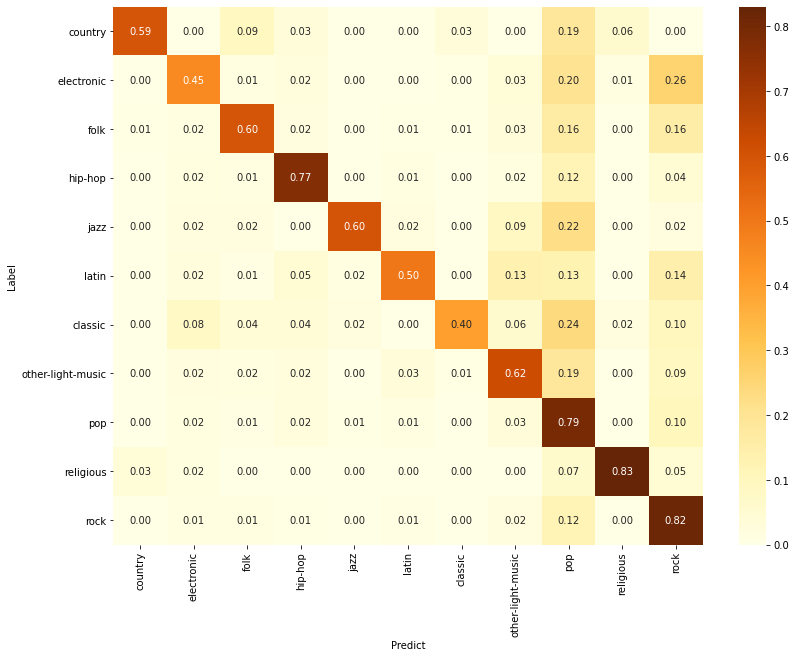

In [7]:
def visualize_confusion_matrix(y_true,
                                                      pred_label,
                                                      height=.6,
                                                      labels=None):
    conf = confusion_matrix(y_true=y_true,
                                               y_pred=pred_label,
                                               normalize='true')
    
    n_labels = len(conf)
    size = n_labels * height
    fig , ax = plt.subplots(figsize=(size*2, size*1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')
    
    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)
        
    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels['genre'])
fig.show()

fold0:Acc 0.5250154416306362
fold1:Acc 0.4749845583693638
fold2:Acc 0.5284301606922126
fold3:Acc 0.48516687268232384
fold4:Acc 0.5253399258343634
--------------------------------------------------
oof score : 0.5077854671280276


(<Figure size 1440x1008 with 2 Axes>,
 array([<AxesSubplot:xlabel='column', ylabel='feature_importance'>,
        <AxesSubplot:>], dtype=object))

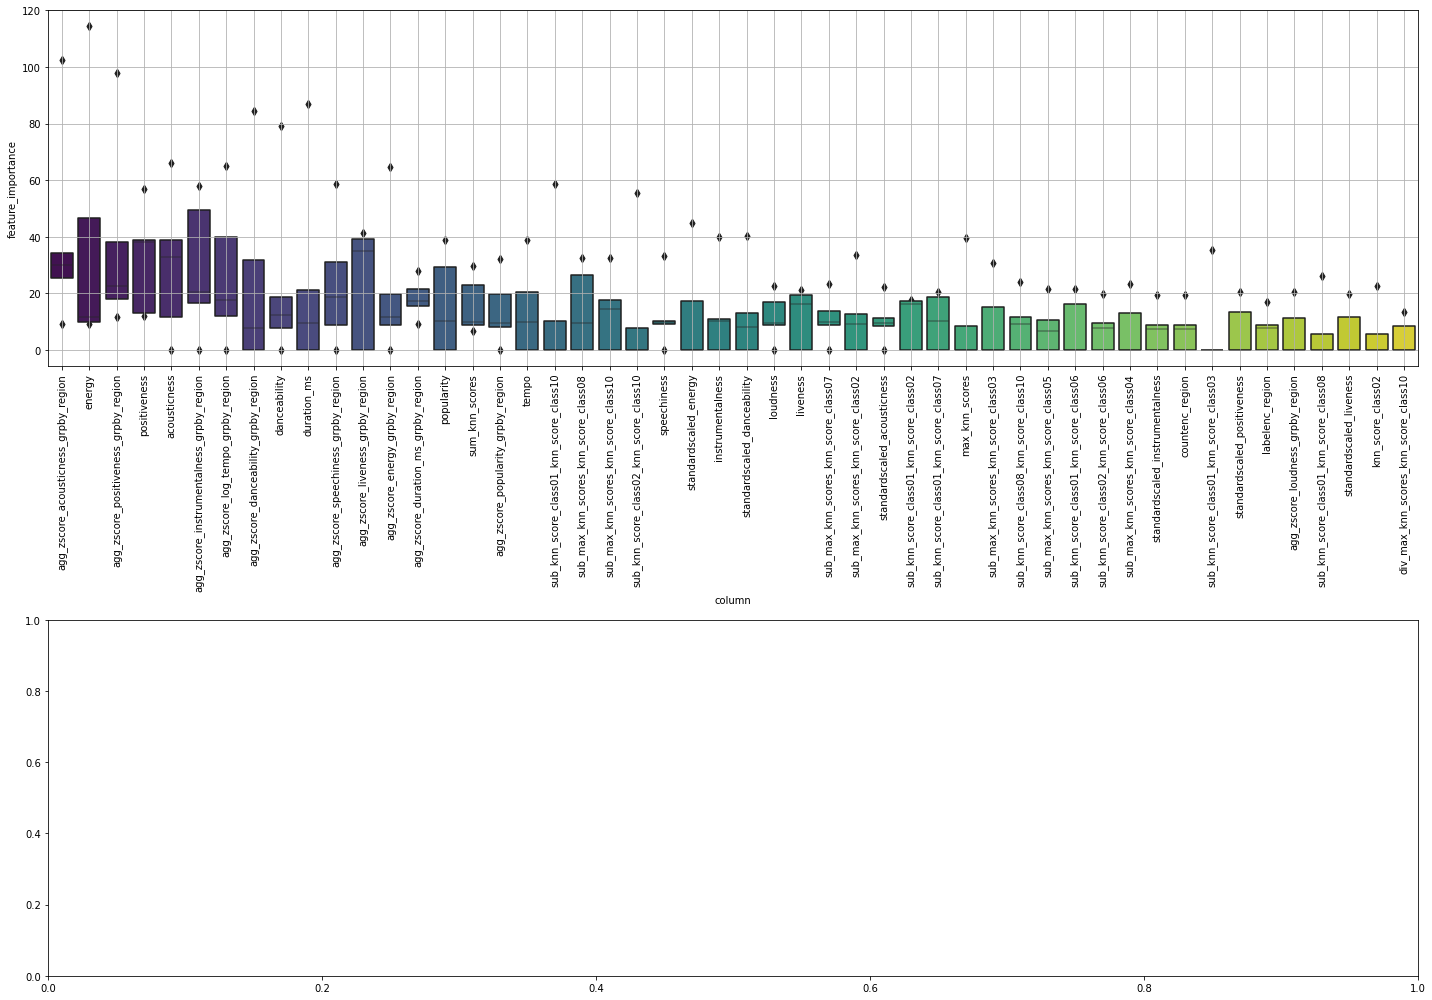

In [8]:
# Adversal Validation
from Adversal_Validation import Lgbm

df_tn = df_train.copy()
df_tt = df_test.copy()

X = df_tn[knn_features].fillna(0.0).values * knn_feature_weights
    
knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target)
df_tn = pd.concat([df_tn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    
X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)

train_feat_df = df_tn.drop(['genre', 'index', 'region', 'genre_name'], axis=1)
test_feat_df = df_tt.drop(['genre', 'index', 'region', 'genre_name', 'prediction'], axis=1)


params = {'boosting_type': 'gbdt',
          'objective': 'cross_entropy',
          'verbosity':-1}

model_ad = Lgbm(params)
model_ad.adversal_validation(train_feat_df,test_feat_df)
model_ad.visualize_importance()

In [9]:
df_sample_sub['genre'] = predictions.argmax(axis=1)
display(df_sample_sub)
df_sample_sub.to_csv('../outputs/sub_0501.csv', index=False, header=False)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8
